## Machine Learning for Biomedical Application
Imbalanced Classification for Biomedical Application

About Dataset
The imbalanced classification dataset is the mammography dataset that involves detecting breast cancer from radiological scans, specifically the presence of clusters
of microcalcification that appear bright on a mammogram. This dataset was constructed by scanning the images, segmenting them into candidate objects, and using computer vision techniques to describe each candidate object.

Features
(description from the woods' paper)
1. Area of object (in pixels).   
- Number of pixels in object.
2. Average gray level of the object.
- Absolute values of calcification pixels are averaged.
3. Gradient strength of the object's perimeter pixels.
- Mean value of Robert's gradient for each perimeter pixel. To perform edge detection with the Roberts Cross operator, the original image is convolved with two 2x2 kernels 
$$
 \left[
 \begin{matrix}
   +1 & 0 \\
   0 & -1
  \end{matrix}
  \right]
$$
- and 
$$
 \left[
 \begin{matrix}
  0 & +1 \\
 -1 & 0
  \end{matrix}
  \right]
$$
- After the convolution, the gradient magnitude can be obtained. The gradient points in the direction of the most rapid change in intensity, and the gradient direction is perpendicular to the edge.
4. Root mean square noise fluctuation in the object.
- In the context of images, noise can be caused by various factors, including sensor imperfections, environmental conditions, and quantization errors during image processing. RMS noise is calculated as the square root of the average of the squares of the individual noise values. (artifact,random dark and bright pixels)
5. Contrast
- average gray level of the object minus the average of a two-pixel wide border surrounding the object.
6. A low order moment based on shape descriptor.
- Image moments are weighted averages of the image pixels' intensities, and they can be used to describe various properties of an object, such as area, centroid, and orientation. Shape descriptor: Calcification aspect ratio defined as maximum radius divided by minimum radius.

There are two classes and the goal is to distinguish between Microcalcification and non-Microcalcification using the features for a given segmented object.

Non-Microcalcification: negative case, or majority class.
Microcalcification: positive case, or minority class.

https://www.kaggle.com/datasets/sudhanshu2198/microcalcification-classification

An image gradient is a directional change in the intensity or color in an image, and it is one of the fundamental building blocks in image processing.
Convoluted the gradient operator

In [1]:
import pandas as pd
import numpy as np

## Data exploration

In [2]:
df = pd.read_csv('microcalcification.csv')
df.head()

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                11183 non-null  float64
 1   Grey Level          11183 non-null  float64
 2   Gradient Strength   11183 non-null  float64
 3   Noise Fluctuation   11183 non-null  float64
 4   Contrast            11183 non-null  float64
 5   Shape Descriptor    11183 non-null  float64
 6   Microcalcification  11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


Use label encoder function to re-label
use 0 to represent the majority class and 1 to represent the minority class

In [4]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('microcalcification.csv')
label_encoder = LabelEncoder()
df['Microcalcification'] = label_encoder.fit_transform(df['Microcalcification'])

ratio about two classes

{0: 10923, 1: 260}
Class   Ratio
0    0.97675
1    0.02325
Name: Microcalcification, dtype: float64


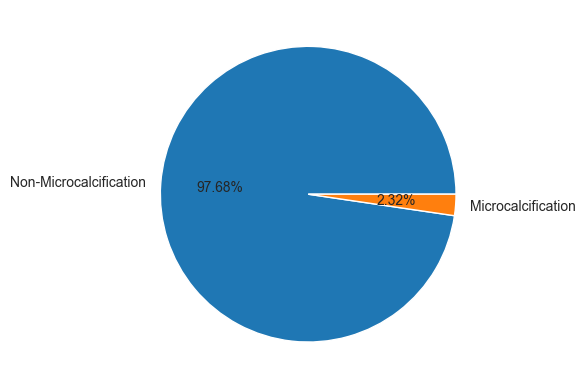

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
from collections import Counter

print(dict(Counter(df['Microcalcification'])))
print('Class   Ratio')
print(df['Microcalcification'].value_counts()/len(df))
plt.pie(df['Microcalcification'].value_counts(),labels=['Non-Microcalcification','Microcalcification'],autopct='%1.2f%%'); # use semicolon to hide the output text

use histogram to show distribution

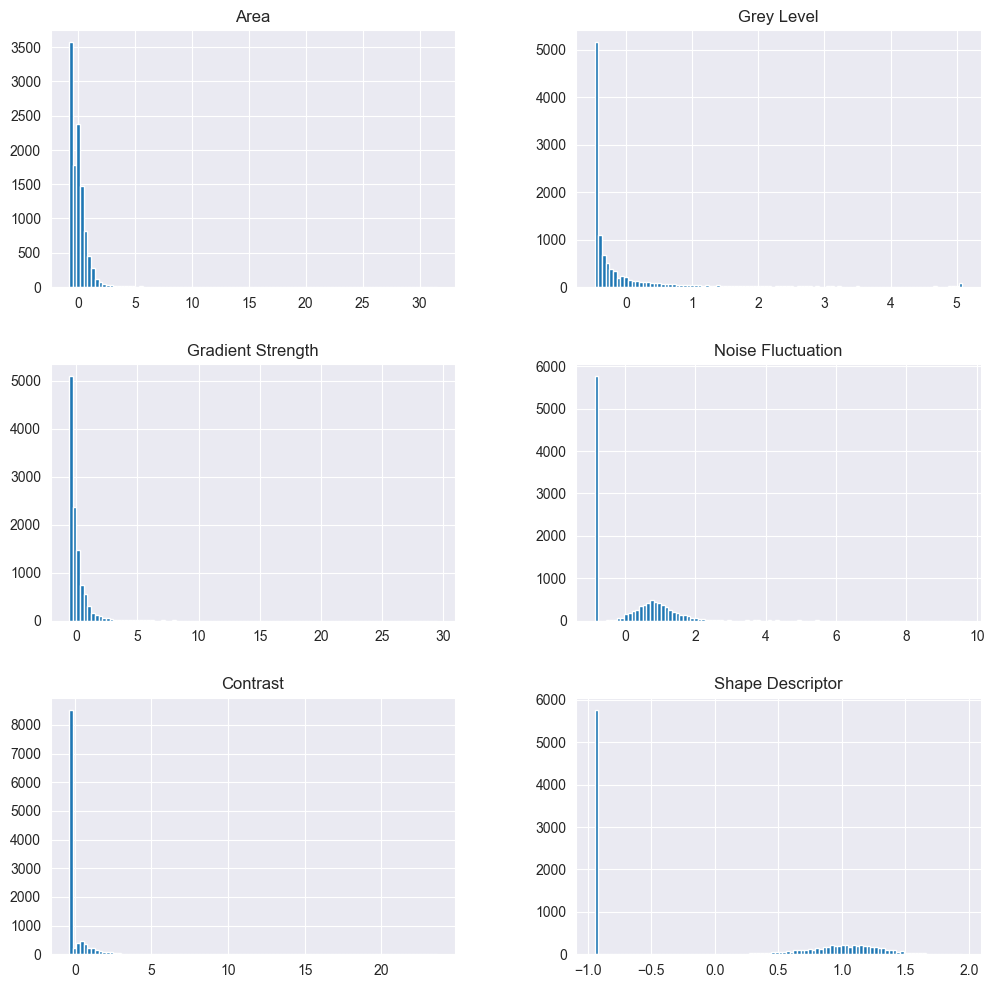

In [6]:
df.drop(columns='Microcalcification').hist(figsize=(12,12),bins=100);

two classes are visually well seperated

Correlation matrix

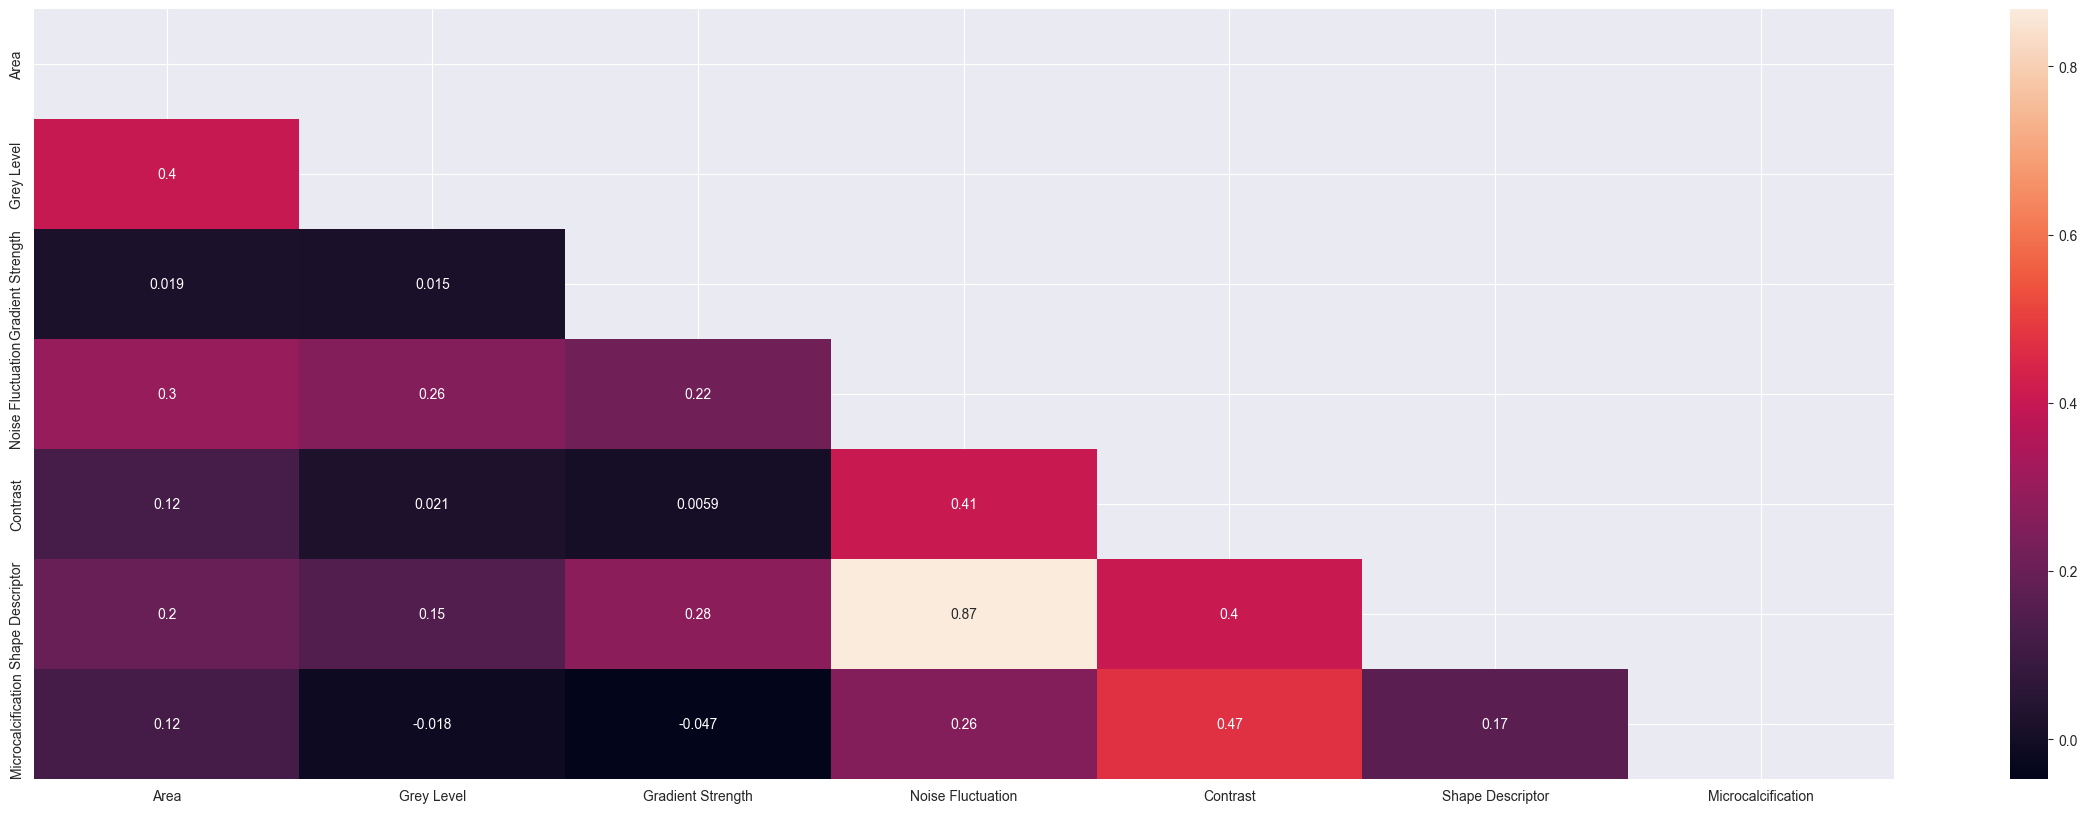

In [7]:
import seaborn as sns
# correlation matrix
cor = df.corr()

# plot heatmap
plt.figure(figsize=(30,10))
mask=np.triu(np.ones_like(df.corr()))
# .triu() returns the upper triangle of an array
# ones_like() returns an array of ones with the same shape and type as a given array
sns.heatmap(cor, annot=True, mask=mask);

## Preprocessing
 normalize dataset to range[0,1], because the negative values may affect classifications in some cases
 Power transformation can make the distribution gaussian like

In [8]:
X = df.drop(columns='Microcalcification')
y = df['Microcalcification']

In [9]:
from sklearn.model_selection import train_test_split
# 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

## Model Evaluation
shuffling need to be considered

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


def evaluate(X, y, model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall', n_jobs=-1)
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision', n_jobs=-1)
    return auc, recall, precision
# 5 fold cross validation

## Baseline Performance

In [11]:
from sklearn.dummy import DummyClassifier

model=DummyClassifier(strategy='stratified')
# DummyClassifier makes predictions that ignore the input features.
# This classifier serves as a simple baseline to compare against other more complex classifiers.
auc, recall, precision= evaluate(X_train,y_train,model)
    
print(f'\nAuc score for Dummy Classifier: {auc.mean()}({auc.std()})')
print(f'\nRecall score for Dummy Classifier: {recall.mean()}({recall.std()})')
print(f'\nPrecision score for Dummy Classifier: {precision.mean()}({precision.std()})')


Auc score for Dummy Classifier: 0.49790897773856085(0.009818773975862012)

Recall score for Dummy Classifier: 0.02868757259001161(0.023305911509673368)

Precision score for Dummy Classifier: 0.038128632125093195(0.015947307497153194)


## Algorithm Spot Checking

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def get_models():
    models,names=list(),list()
    
    models.append(LogisticRegression())
    names.append('LR')
    
    models.append(SVC(probability=True))
    names.append('SVM')
    
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # It is easy to overfit with too few trees, adding more trees can reduce the overfitting, but there is no way to eliminate it completely
    # https://escholarship.org/content/qt35x3v9t4/qt35x3v9t4.pdf
    
    models.append(xgb.XGBClassifier())
    names.append('XGBoost')
    
    return models,names

In [13]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

models,names=get_models()
results1=list()
results2=list()
results3=list()
z1=list()
z2=list()
z3=list()

for i in range(len(models)):
    
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',models[i])]
    pipeline=Pipeline(steps=steps)
    # use pipeline to avoid information leaking
    # Need to include preprocessing in cross-validation
    # https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/#15
    # https://machinelearningmastery.com/data-preparation-without-data-leakage/
    auc, recall, precision = evaluate(X_train,y_train,pipeline) # like this
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())
    
    print(f'Auc score for {names[i]}: {auc.mean()}({auc.std()})')
    print(f'Recall score for {names[i]}: {recall.mean()}({recall.std()})')
    print(f'Precision score for {names[i]}: {precision.mean()}({precision.std()})')

# store to the final csv  
df1_auc = pd.DataFrame(z1)
df1_auc = df1_auc.T
df1_recall = pd.DataFrame(z2)
df1_recall = df1_recall.T
df1_precision = pd.DataFrame(z3)
df1_precision = df1_precision.T

Auc score for LR: 0.9116334922842922(0.02147728418251929)
Recall score for LR: 0.28315911730545873(0.09156142086129666)
Precision score for LR: 0.7632792207792207(0.05687012262052182)
Auc score for SVM: 0.8729056657531388(0.0501463536082928)
Recall score for SVM: 0.43704994192799074(0.09309332522395415)
Precision score for SVM: 0.8153643966547193(0.06719928721506482)
Auc score for RF: 0.9427579165056589(0.00991077010752529)
Recall score for RF: 0.5284552845528455(0.08002398736047495)
Precision score for RF: 0.8968590577376846(0.03302942814865178)
Auc score for XGBoost: 0.9274952387834864(0.01953084688089563)
Recall score for XGBoost: 0.5815331010452962(0.05888581919931004)
Precision score for XGBoost: 0.8287906537906539(0.03877299537708349)


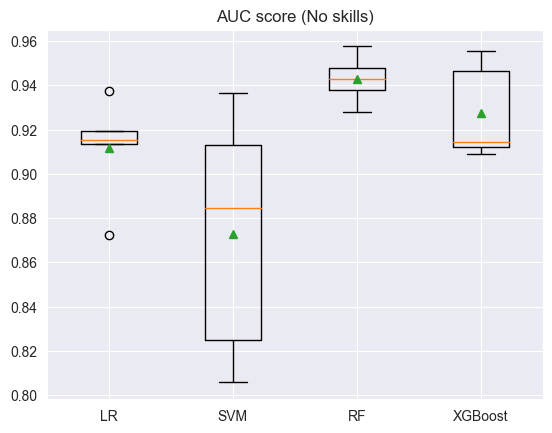

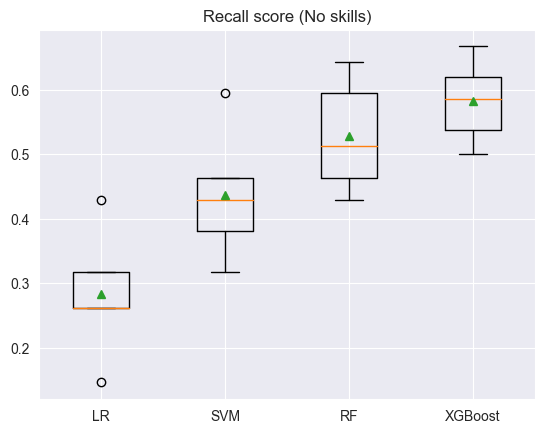

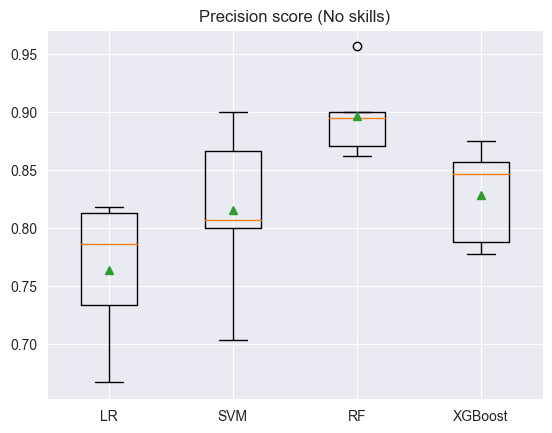

In [14]:
plt.figure()
plt.boxplot(results1,labels=names,showmeans=True);
plt.title("AUC score (No skills)");
plt.figure()
plt.boxplot(results2,labels=names,showmeans=True);
plt.title("Recall score (No skills)");
plt.figure()
plt.boxplot(results3,labels=names,showmeans=True);
plt.title("Precision score (No skills)");

minimum, first quartile (Q1), median (Q2), third quartile (Q3), and maximum
a green triangle is used to represent the mean of the data
In a boxplot, a red line typically represents the median of the data (middle value)
A boxplot with a circle typically indicates the presence of an outlier in the data
 Values that are more than 1.5 times the interquartile range (IQR) away from the box are considered to be outliers

## Data Sampling

In [15]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RandomUnderSampler

# creat a list that contain these resample functions
def get_sampling():
    
    sampling,seq=list(),list()
    
    sampling.append(RandomUnderSampler()) # undersample
    seq.append('RUS')
    
    sampling.append(RandomUnderSampler(sampling_strategy={0:3000})) # undersample
    seq.append('RUS(strategy)')
    
    sampling.append(TomekLinks()) # undersample
    seq.append('TL')
    
    sampling.append(EditedNearestNeighbours()) # undersample 
    # Edited Nearest Neighbours (ENN) is an undersampling technique used to handle imbalanced datasets by removing samples close to the decision boundary
    seq.append('ENN')
    
    sampling.append(ADASYN()) # oversample
    seq.append('ADASYN')
    
    sampling.append(SMOTE()) # oversample
    seq.append('SMOTE')
    
    sampling.append(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))) # ensemble method
    seq.append('SMOTETomek')
    
    sampling.append(SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))) # ensemble method
    seq.append('SMOTEENN')
    
    # sampling.append(sv.MSMOTE()) # ensemble method
    # seq.append('MSMOTE')
    
    return sampling,seq

Auc score for RUS: 0.9147900767632429(0.024287215182301574), resampled y_train: {0: 208, 1: 208}
Recall score for RUS: 0.8409988385598142(0.04572063542390822), resampled y_train: {0: 208, 1: 208}
Precision score for RUS: 0.11192335726854863(0.007536122774819808), resampled y_train: {0: 208, 1: 208}
Auc score for RUS(strategy): 0.911458427203949(0.021542982686334262), resampled y_train: {0: 3000, 1: 208}
Recall score for RUS(strategy): 0.49953542392566785(0.09938318187127679), resampled y_train: {0: 3000, 1: 208}
Precision score for RUS(strategy): 0.7005253518411413(0.06065701741481283), resampled y_train: {0: 3000, 1: 208}
Auc score for TL: 0.9116663633255191(0.02149614427252159), resampled y_train: {0: 8708, 1: 208}
Recall score for TL: 0.29767711962833915(0.08554351924402061), resampled y_train: {0: 8708, 1: 208}
Precision score for TL: 0.7431884057971014(0.04149485686681927), resampled y_train: {0: 8708, 1: 208}
Auc score for ENN: 0.9117640820992265(0.021409297006735998), resampled 

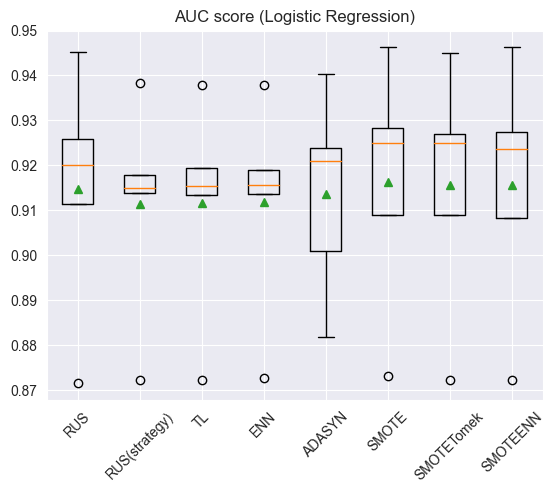

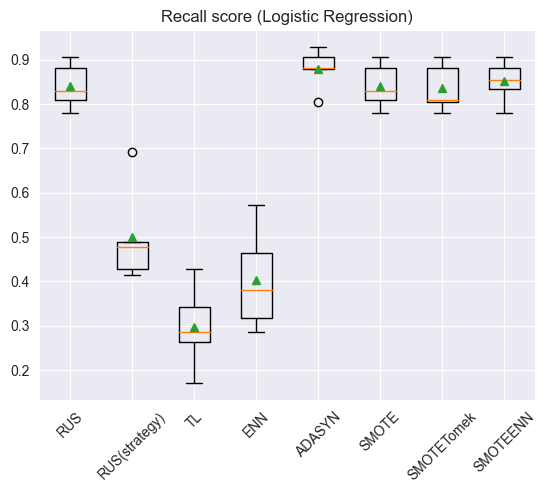

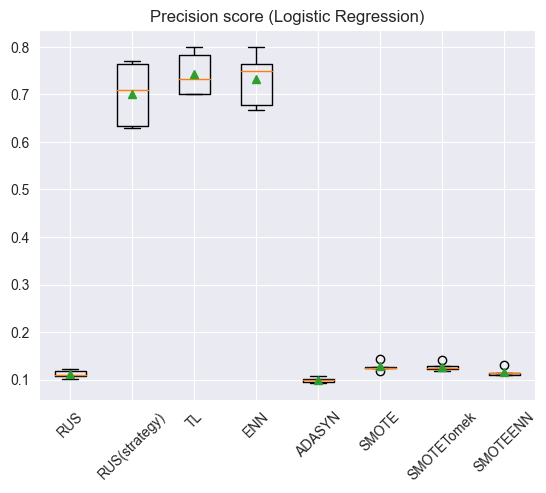

In [16]:
# Logistic Regression
sampling,seq=get_sampling()
results1=list()
results2=list()
results3=list()
nums=list()
z1=list()
z2=list()
z3=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',LogisticRegression())]
    pipeline=Pipeline(steps=steps)
        
    auc, recall, precision =evaluate(X_train,y_train,pipeline)
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())

    # output the number of samples after resampling
    res_X, y_res = sampling[i].fit_resample(X_train,y_train)
    nums.append(dict(Counter(y_res)))

    print(f'Auc score for {seq[i]}: {auc.mean()}({auc.std()}), resampled y_train: {nums[i]}')
    print(f'Recall score for {seq[i]}: {recall.mean()}({recall.std()}), resampled y_train: {nums[i]}')
    print(f'Precision score for {seq[i]}: {precision.mean()}({precision.std()}), resampled y_train: {nums[i]}')


df2_auc1 = z1
df2_recall1 = z2
df2_precision1 = z3
    
print('\n')

plt.figure()
plt.boxplot(results1,labels=seq,showmeans=True);
plt.title("AUC score (Logistic Regression)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results2,labels=seq,showmeans=True);
plt.title("Recall score (Logistic Regression)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results3,labels=seq,showmeans=True);
plt.title("Precision score (Logistic Regression)");
plt.xticks(rotation=45);

Sampling does not make logistic regression models perform better
compare with 0.91

Auc score for RUS: 0.9425026011721132(0.011133004442881084), resampled y_train: {0: 208, 1: 208}
Recall score for RUS: 0.8221835075493613(0.02395327838647695), resampled y_train: {0: 208, 1: 208}
Precision score for RUS: 0.18757387891448446(0.01739308989921437), resampled y_train: {0: 208, 1: 208}
Auc score for RUS(strategy): 0.9104138851583802(0.025063457755070673), resampled y_train: {0: 3000, 1: 208}
Recall score for RUS(strategy): 0.5815331010452962(0.07866783420272852), resampled y_train: {0: 3000, 1: 208}
Precision score for RUS(strategy): 0.7477884615384616(0.04401970835963298), resampled y_train: {0: 3000, 1: 208}
Auc score for TL: 0.8771015109157195(0.05018345877766628), resampled y_train: {0: 8708, 1: 208}
Recall score for TL: 0.45133565621370497(0.10185400012360235), resampled y_train: {0: 8708, 1: 208}
Precision score for TL: 0.8055628751280925(0.060908023248766874), resampled y_train: {0: 8708, 1: 208}
Auc score for ENN: 0.8892412604139629(0.03895898015413327), resampled y

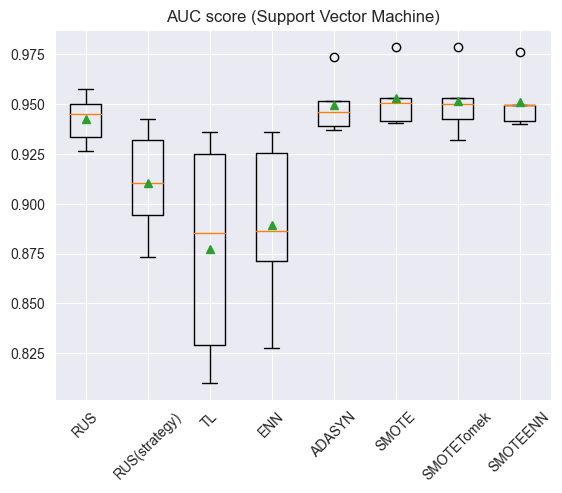

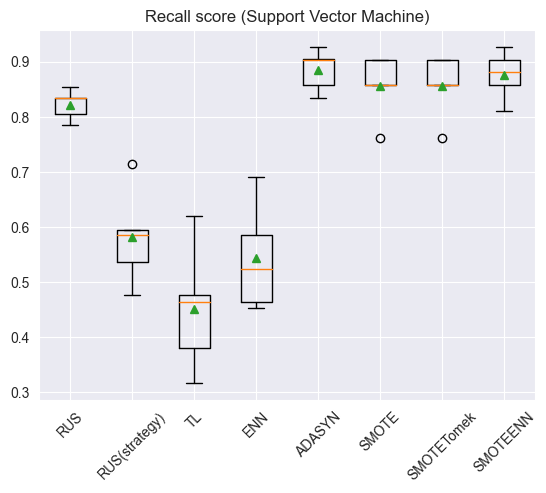

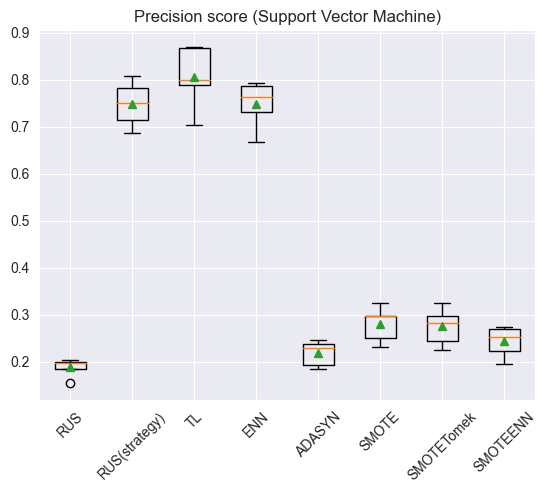

In [17]:
# Support Vector Machine
sampling,seq=get_sampling()
results1=list()
results2=list()
results3=list()
nums=list()
z1=list()
z2=list()
z3=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',SVC(probability=True))]
    pipeline=Pipeline(steps=steps)
        
    auc, recall, precision=evaluate(X_train,y_train,pipeline)
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())

    # output the number of samples after resampling
    res_X, y_res = sampling[i].fit_resample(X_train,y_train)
    nums.append(dict(Counter(y_res)))

    print(f'Auc score for {seq[i]}: {auc.mean()}({auc.std()}), resampled y_train: {nums[i]}')
    print(f'Recall score for {seq[i]}: {recall.mean()}({recall.std()}), resampled y_train: {nums[i]}')
    print(f'Precision score for {seq[i]}: {precision.mean()}({precision.std()}), resampled y_train: {nums[i]}')

df2_auc2 = z1
df2_recall2 = z2
df2_precision2 = z3
  
print('\n')

plt.figure()
plt.boxplot(results1,labels=seq,showmeans=True);
plt.title("AUC score (Support Vector Machine)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results2,labels=seq,showmeans=True);
plt.title("Recall score (Support Vector Machine)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results3,labels=seq,showmeans=True);
plt.title("Precision score (Support Vector Machine)");
plt.xticks(rotation=45);

Sampling makes Support Vector Machine models perform better (RUS, SMOTE, SMOTETomek, SMOTEENN)
compare with 0.87

Auc score for RUS: 0.9443853405255455(0.013990571359592632), resampled y_train: {0: 208, 1: 208}
Recall score for RUS: 0.8607433217189314(0.037685825843569595), resampled y_train: {0: 208, 1: 208}
Precision score for RUS: 0.1990493855474527(0.008962399900387634), resampled y_train: {0: 208, 1: 208}
Auc score for RUS(strategy): 0.9443788992470298(0.011185325233319526), resampled y_train: {0: 3000, 1: 208}
Recall score for RUS(strategy): 0.6202090592334495(0.05077632656412751), resampled y_train: {0: 3000, 1: 208}
Precision score for RUS(strategy): 0.7234891468123175(0.016183958728801816), resampled y_train: {0: 3000, 1: 208}
Auc score for TL: 0.9448005917060499(0.00739656512510913), resampled y_train: {0: 8708, 1: 208}
Recall score for TL: 0.5428571428571428(0.08736809798139572), resampled y_train: {0: 8708, 1: 208}
Precision score for TL: 0.8818657826511963(0.03168230495605159), resampled y_train: {0: 8708, 1: 208}
Auc score for ENN: 0.9468191196092952(0.015128526418301034), resampled 

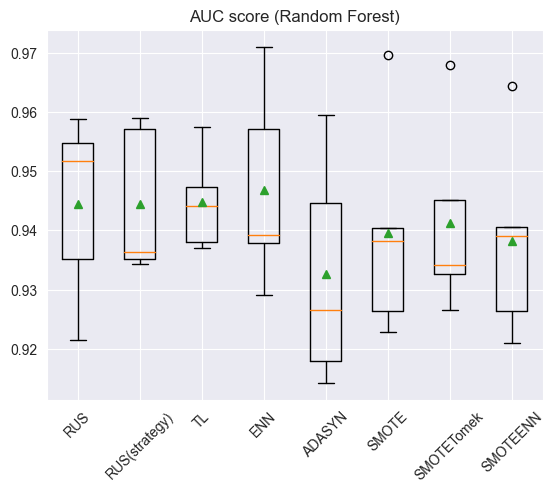

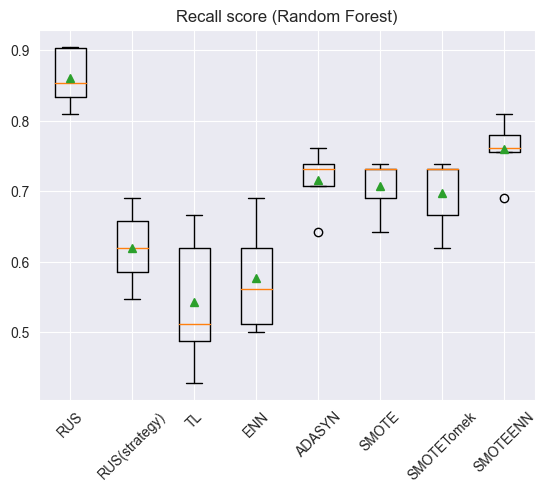

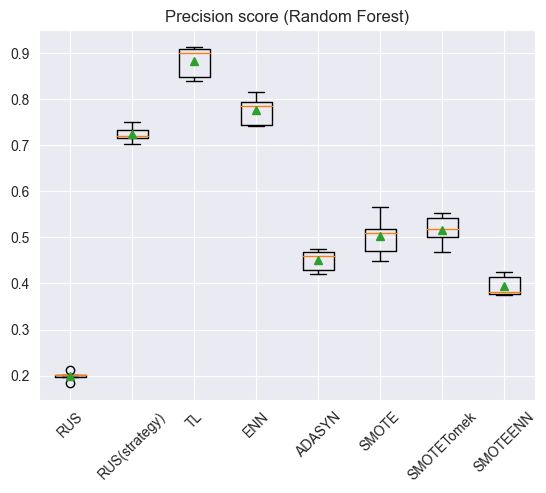

In [18]:
# Random Forest
sampling,seq=get_sampling()
results1=list()
results2=list()
results3=list()
nums=list()
z1=list()
z2=list()
z3=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',RandomForestClassifier(n_estimators=1000))]
    pipeline=Pipeline(steps=steps)
        
    auc, recall, precision =evaluate(X_train,y_train,pipeline)
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())

    # output the number of samples after resampling
    res_X, y_res = sampling[i].fit_resample(X_train,y_train)
    nums.append(dict(Counter(y_res)))

    print(f'Auc score for {seq[i]}: {auc.mean()}({auc.std()}), resampled y_train: {nums[i]}')
    print(f'Recall score for {seq[i]}: {recall.mean()}({recall.std()}), resampled y_train: {nums[i]}')
    print(f'Precision score for {seq[i]}: {precision.mean()}({precision.std()}), resampled y_train: {nums[i]}')

df2_auc3 = z1
df2_recall3 = z2
df2_precision3 = z3
    
print('\n')

plt.figure()
plt.boxplot(results1,labels=seq,showmeans=True);
plt.title("AUC score (Random Forest)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results2,labels=seq,showmeans=True);
plt.title("Recall score (Random Forest)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results3,labels=seq,showmeans=True);
plt.title("Precision score (Random Forest)");
plt.xticks(rotation=45);

Sampling does not make Random Forest models perform better
compare with 0.94

Auc score for RUS: 0.9377051404174033(0.011638445327647254), resampled y_train: {0: 208, 1: 208}
Recall score for RUS: 0.8797909407665505(0.03435979017347385), resampled y_train: {0: 208, 1: 208}
Precision score for RUS: 0.1708655922141279(0.008121658697995561), resampled y_train: {0: 208, 1: 208}
Auc score for RUS(strategy): 0.9340763790113262(0.01626795585979991), resampled y_train: {0: 3000, 1: 208}
Recall score for RUS(strategy): 0.654006968641115(0.04805387713472659), resampled y_train: {0: 3000, 1: 208}
Precision score for RUS(strategy): 0.6850454801032464(0.018829639410973587), resampled y_train: {0: 3000, 1: 208}
Auc score for TL: 0.9272735901830998(0.019771426321938422), resampled y_train: {0: 8708, 1: 208}
Recall score for TL: 0.5910569105691057(0.07220796092696573), resampled y_train: {0: 8708, 1: 208}
Precision score for TL: 0.8253612128612128(0.015864270129579142), resampled y_train: {0: 8708, 1: 208}
Auc score for ENN: 0.9337220239360411(0.01458929380953022), resampled y_

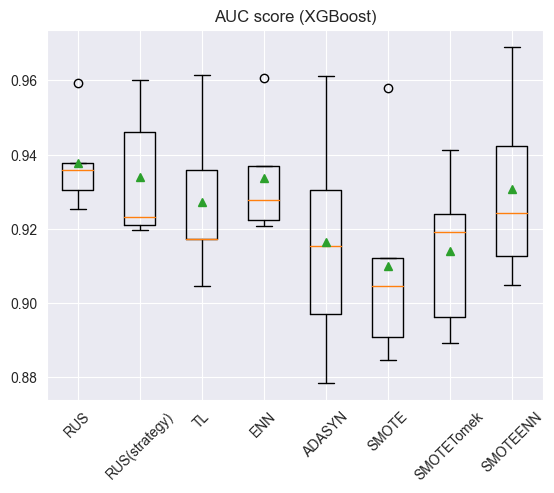

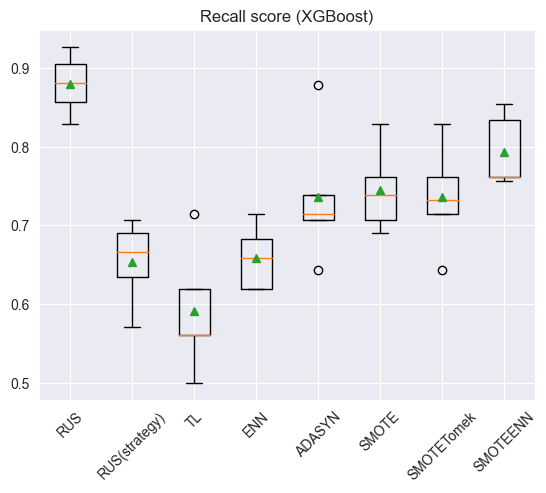

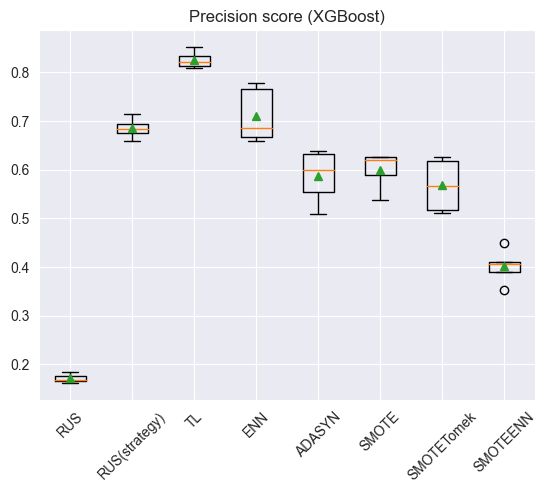

In [19]:
# XGBoost
sampling,seq=get_sampling()
results1=list()
results2=list()
results3=list()
nums=list()
z1=list()
z2=list()
z3=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',xgb.XGBClassifier())]
    pipeline=Pipeline(steps=steps)
        
    auc, recall, precision=evaluate(X_train,y_train,pipeline)
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())

    # output the number of samples after resampling
    res_X, y_res = sampling[i].fit_resample(X_train,y_train)
    nums.append(dict(Counter(y_res)))

    print(f'Auc score for {seq[i]}: {auc.mean()}({auc.std()}), resampled y_train: {nums[i]}')
    print(f'Recall score for {seq[i]}: {recall.mean()}({recall.std()}), resampled y_train: {nums[i]}')
    print(f'Precision score for {seq[i]}: {precision.mean()}({precision.std()}), resampled y_train: {nums[i]}')

df2_auc4 = z1
df2_recall4 = z2
df2_precision4 = z3
# combine to one form of second part
df2_auc = pd.DataFrame(list(zip(df2_auc1, df2_auc2, df2_auc3, df2_auc4)))
df2_recall = pd.DataFrame(list(zip(df2_recall1, df2_recall2, df2_recall3, df2_recall4)))
df2_precision = pd.DataFrame(list(zip(df2_precision1, df2_precision2, df2_precision3, df2_precision4)))

print('\n')

plt.figure()
plt.boxplot(results1,labels=seq,showmeans=True);
plt.title("AUC score (XGBoost)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results2,labels=seq,showmeans=True);
plt.title("Recall score (XGBoost)");
plt.xticks(rotation=45);
plt.figure()
plt.boxplot(results3,labels=seq,showmeans=True);
plt.title("Precision score (XGBoost)");
plt.xticks(rotation=45);

slightly increase in xgb performance
compare with 0.92

## Cost Sensitive Learning
Instead of trying to optimize the accuracy, the problem is then to minimize the total misclassification cost

In [20]:
# use the hyperparameter class_weight to implement
def get_csl_models():
    models,names=list(),list()
    
    models.append(LogisticRegression(class_weight='balanced'))
    names.append('LR')
    
    models.append(SVC(probability=True,class_weight='balanced'))
    names.append('SVM')
    
    models.append(RandomForestClassifier(n_estimators=1000,class_weight='balanced'))
    names.append('RF')
    
    models.append(xgb.XGBClassifier(scale_pos_weight=float(np.sum(y_train == 0)) / np.sum(y_train == 1), seed=42))
    names.append('XGBoost')
    
    return models,names

In [21]:
models,names=get_csl_models()
results1=list()
results2=list()
results3=list()
z1=list()
z2=list()
z3=list()
for i in range(len(models)):
    
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',models[i])]
    pipeline=Pipeline(steps=steps)
    
    auc, recall, precision=evaluate(X_train,y_train,pipeline)
    results1.append(auc)
    results2.append(recall)
    results3.append(precision)
    z1.append(auc.mean())
    z2.append(recall.mean())
    z3.append(precision.mean())
    
    
    print(f'Auc score for {names[i]}: {auc.mean()}({auc.std()})')
    print(f'Recall score for {names[i]}: {recall.mean()}({recall.std()})')
    print(f'Precision score for {names[i]}: {precision.mean()}({precision.std()})')
    
# store to the final table 
df3_auc = pd.DataFrame(z1)
df3_auc = df3_auc.T
df3_recall = pd.DataFrame(z2)
df3_recall = df3_recall.T
df3_precision = pd.DataFrame(z3)
df3_precision = df3_precision.T

Auc score for LR: 0.9167190810328603(0.02470598944875057)
Recall score for LR: 0.8313588850174216(0.041677096065506264)
Precision score for LR: 0.12206465507604032(0.008169879875877011)
Auc score for SVM: 0.9551156944170802(0.012371886264589427)
Recall score for SVM: 0.8657375145180023(0.04336606760587959)
Precision score for SVM: 0.24608596353590792(0.02920926575482835)
Auc score for RF: 0.9100303535458891(0.023605275260754368)
Recall score for RF: 0.4758420441347271(0.07800919160775513)
Precision score for RF: 0.8743426943426943(0.045537890174517405)
Auc score for XGBoost: 0.8905625214914978(0.02004696706804715)
Recall score for XGBoost: 0.6536585365853659(0.05697760871641967)
Precision score for XGBoost: 0.7191142191142191(0.053238837913180355)


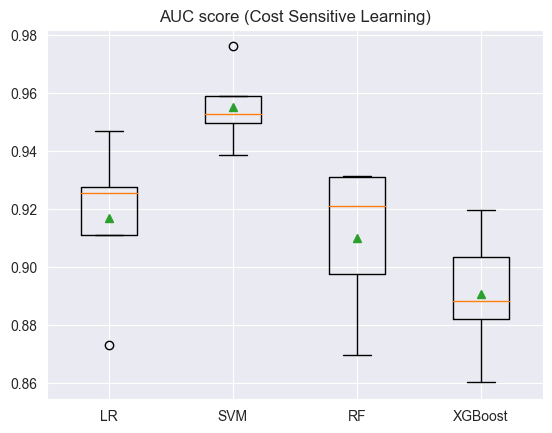

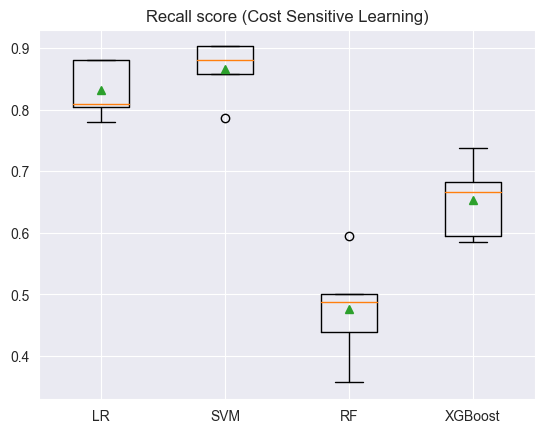

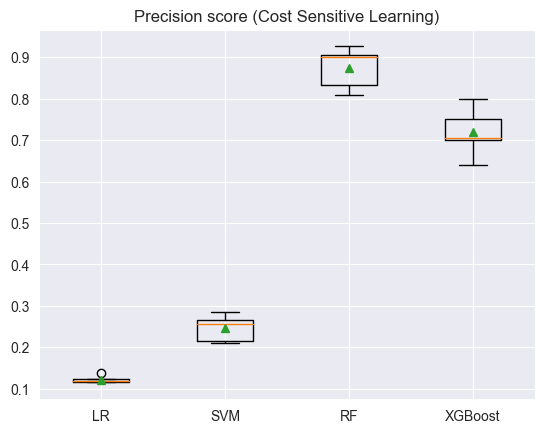

In [22]:
plt.figure()
plt.boxplot(results1,labels=names,showmeans=True);
plt.title("AUC score (Cost Sensitive Learning)");
plt.figure()
plt.boxplot(results2,labels=names,showmeans=True);
plt.title("Recall score (Cost Sensitive Learning)");
plt.figure()
plt.boxplot(results3,labels=names,showmeans=True);
plt.title("Precision score (Cost Sensitive Learning)");

Cost-sensitive learning can significantly improve the performance of support vector machines
compare with 0.91 0.87 0.94 0.92

## Model Selection
choose the model with best performance above

In [23]:
ind = ['No skill'] + seq +['Cost Sensitive Learning']
df_auc = pd.concat([df1_auc, df2_auc, df3_auc], ignore_index=True)
df_auc.index = ind
df_auc.columns = names

df_recall = pd.concat([df1_recall, df2_recall, df3_recall], ignore_index=True)
df_recall.index = ind
df_recall.columns = names

df_precision = pd.concat([df1_precision, df2_precision, df3_precision], ignore_index=True)
df_precision.index = ind
df_precision.columns = names

df_auc = df_auc.T
df_recall = df_recall.T
df_precision = df_precision.T
df_auc.to_csv("AUC scores.csv", index=True)
df_recall.to_csv("Recall scores.csv", index=True)
df_precision.to_csv("Precision scores.csv", index=True)

In [24]:
biggest_value = df_auc.max().max()
column_name = df_auc.max().idxmax()
row_name = df_auc[column_name].idxmax()
print("Biggest AUC score:", biggest_value, row_name, column_name)
df_auc

Biggest AUC score: 0.9551156944170802 SVM Cost Sensitive Learning


,No skill,RUS,RUS(strategy),TL,ENN,ADASYN,SMOTE,SMOTETomek,SMOTEENN,Cost Sensitive Learning
LR,0.911633,0.914790,0.911458,0.911666,0.911764,0.913577,0.916301,0.915580,0.915532,0.916719
SVM,0.872906,0.942503,0.910414,0.877102,0.889241,0.949382,0.952837,0.951248,0.951209,0.955116
RF,0.942758,0.944385,0.944379,0.944801,0.946819,0.932589,0.939512,0.941249,0.938276,0.910030
XGBoost,0.927495,0.937705,0.934076,0.927274,0.933722,0.916504,0.910011,0.913999,0.930698,0.890563


In [25]:
biggest_value = df_recall.max().max()
column_name = df_recall.max().idxmax()
row_name = df_recall[column_name].idxmax()
print("Biggest Recall score:", biggest_value, row_name, column_name)
df_recall

Biggest Recall score: 0.8849012775842043 SVM ADASYN


,No skill,RUS,RUS(strategy),TL,ENN,ADASYN,SMOTE,SMOTETomek,SMOTEENN,Cost Sensitive Learning
LR,0.283159,0.840999,0.499535,0.297677,0.403717,0.879443,0.840999,0.836121,0.850639,0.831359
SVM,0.437050,0.822184,0.581533,0.451336,0.543089,0.884901,0.856214,0.856214,0.875377,0.865738
RF,0.528455,0.860743,0.620209,0.542857,0.576539,0.716376,0.706969,0.697445,0.759698,0.475842
XGBoost,0.581533,0.879791,0.654007,0.591057,0.658769,0.736121,0.745412,0.736005,0.793380,0.653659


In [26]:
biggest_value = df_precision.max().max()
column_name = df_precision.max().idxmax()
row_name = df_precision[column_name].idxmax()
print("Biggest Precision score:", biggest_value, row_name, column_name)
df_precision

Biggest Precision score: 0.8968590577376846 RF No skill


,No skill,RUS,RUS(strategy),TL,ENN,ADASYN,SMOTE,SMOTETomek,SMOTEENN,Cost Sensitive Learning
LR,0.763279,0.111923,0.700525,0.743188,0.731989,0.099257,0.127701,0.127267,0.115261,0.122065
SVM,0.815364,0.187574,0.747788,0.805563,0.747595,0.217976,0.279574,0.274701,0.243394,0.246086
RF,0.896859,0.199049,0.723489,0.881866,0.775299,0.450274,0.501857,0.516246,0.394589,0.874343
XGBoost,0.828791,0.170866,0.685045,0.825361,0.710379,0.586385,0.599054,0.567253,0.401629,0.719114


find max value of each metric

## Choose model according to the higest AUC

In [36]:
model=SVC(probability=True,class_weight='balanced')

steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',model)]
pipeline=Pipeline(steps=steps)

pipeline.fit(X_train,y_train)
y_probs=pipeline.predict_proba(X_test)[:,1]

roc curve

Best Threshold=0.054155, g_means=0.959


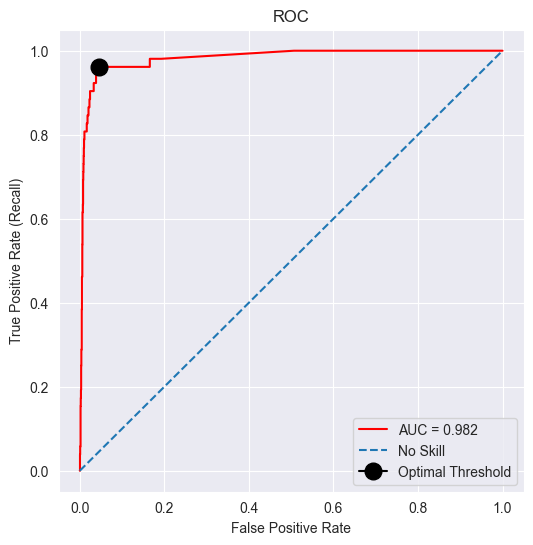

In [37]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
                                     
roc_auc = auc(fpr, tpr) # roc_auc_score(y_test, y_probs)

g_means = np.sqrt(tpr*(1-fpr))
ix = np.argmax(g_means)
thresh=thresholds[ix]

print('Best Threshold=%f, g_means=%.3f' % (thresholds[ix], g_means[ix]))

plt.figure(figsize=(6,6))
plt.title('ROC')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'--',label='No Skill')
plt.plot(fpr[ix],tpr[ix],marker='o', markersize=12,color='black',label='Optimal Threshold');
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

Threshold Moving

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2185
           1       0.34      0.96      0.50        52

    accuracy                           0.96      2237
   macro avg       0.67      0.96      0.74      2237
weighted avg       0.98      0.96      0.97      2237


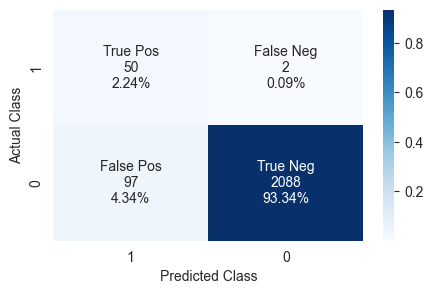

balanced-accuracy:0.959


In [38]:
from numpy import flip
from sklearn.metrics import classification_report, confusion_matrix

y_pred=(y_probs>=thresh) # 

print(f"Classification report:\n{classification_report(y_test, y_pred)}")

# Define a function to plot the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_prediction):
    cm = flip(confusion_matrix(y_true, y_prediction))
    group_names = ["True Pos", "False Neg", "False Pos", "True Neg"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)] # flatten() is used to return a copy of a given array
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    # ax.set_title(f'Logistic Regression Classification')
    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()

# plot the confusion matrix as a heatmap
plot_confusion_matrix(y_test, y_pred)

from sklearn.metrics import balanced_accuracy_score
# balanced-accuracy = (tpr+tnr)/2
print('balanced-accuracy:%.3f'%balanced_accuracy_score(y_test, y_pred))

Although the sample size of FP is higher, the sample size of FN is at a lower level, which is more reasonable in practical applications

## Choose model according to the highest recall

In [39]:
model=SVC(probability=True)

steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',ADASYN()),('m',model)]
pipeline=Pipeline(steps=steps)

pipeline.fit(X_train,y_train)
y_probs=pipeline.predict_proba(X_test)[:,1]

roc curve

Best Threshold=0.770155, g_means=0.952


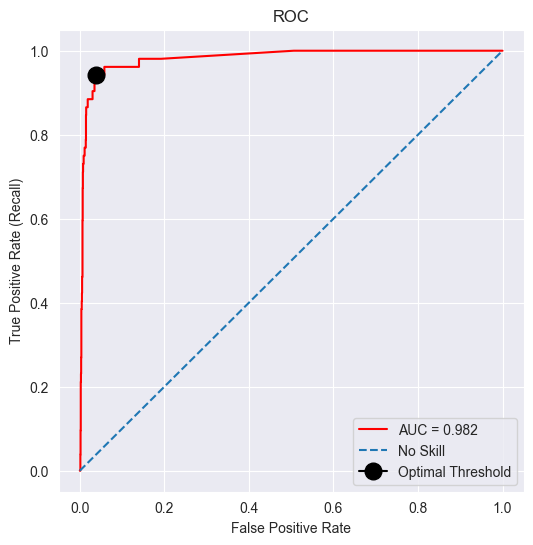

In [40]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
                                     
roc_auc = auc(fpr, tpr) # roc_auc_score(y_test, y_probs)

g_means = np.sqrt(tpr*(1-fpr))
ix = np.argmax(g_means)
thresh=thresholds[ix]

print('Best Threshold=%f, g_means=%.3f' % (thresholds[ix], g_means[ix]))

plt.figure(figsize=(6,6))
plt.title('ROC')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'--',label='No Skill')
plt.plot(fpr[ix],tpr[ix],marker='o', markersize=12,color='black',label='Optimal Threshold');
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

threshold moving

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2185
           1       0.37      0.94      0.53        52

    accuracy                           0.96      2237
   macro avg       0.68      0.95      0.75      2237
weighted avg       0.98      0.96      0.97      2237


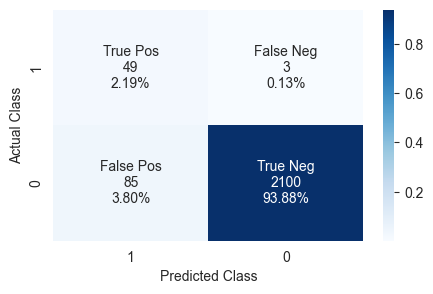

balanced-accuracy:0.952


In [41]:
from numpy import flip
from sklearn.metrics import classification_report, confusion_matrix

y_pred=(y_probs>=thresh) # 

print(f"Classification report:\n{classification_report(y_test, y_pred)}")

# Define a function to plot the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_prediction):
    cm = flip(confusion_matrix(y_true, y_prediction))
    group_names = ["True Pos", "False Neg", "False Pos", "True Neg"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)] # flatten() is used to return a copy of a given array
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    # ax.set_title(f'Logistic Regression Classification')
    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()

# plot the confusion matrix as a heatmap
plot_confusion_matrix(y_test, y_pred)

from sklearn.metrics import balanced_accuracy_score
# balanced-accuracy = (tpr+tnr)/2
print('balanced-accuracy:%.3f'%balanced_accuracy_score(y_test, y_pred))

## Choose model according to the highest precision

In [43]:
model=RandomForestClassifier()

steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',model)]
pipeline=Pipeline(steps=steps)

pipeline.fit(X_train,y_train)
y_probs=pipeline.predict_proba(X_test)[:,1]

roc curve

Best Threshold=0.050000, g_means=0.957


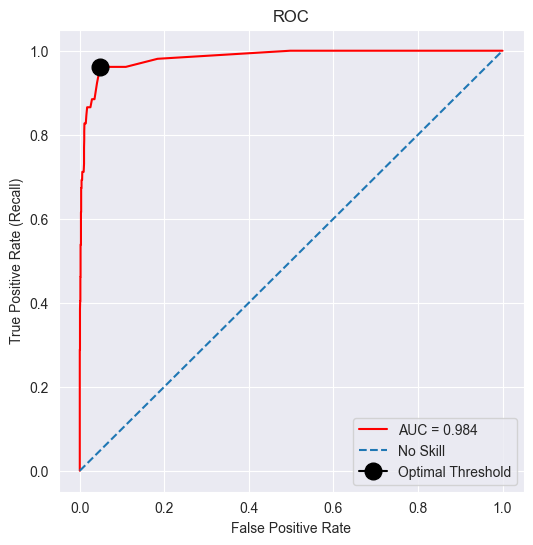

In [44]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
                                     
roc_auc = auc(fpr, tpr) # roc_auc_score(y_test, y_probs)

g_means = np.sqrt(tpr*(1-fpr))
ix = np.argmax(g_means)
thresh=thresholds[ix]

print('Best Threshold=%f, g_means=%.3f' % (thresholds[ix], g_means[ix]))

plt.figure(figsize=(6,6))
plt.title('ROC')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'--',label='No Skill')
plt.plot(fpr[ix],tpr[ix],marker='o', markersize=12,color='black',label='Optimal Threshold');
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

threshold moving

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2185
           1       0.32      0.96      0.48        52

    accuracy                           0.95      2237
   macro avg       0.66      0.96      0.73      2237
weighted avg       0.98      0.95      0.96      2237


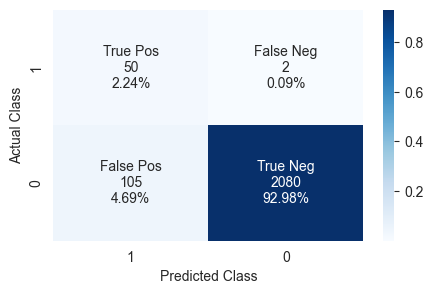

balanced-accuracy:0.957


In [45]:
from numpy import flip
from sklearn.metrics import classification_report, confusion_matrix

y_pred=(y_probs>=thresh) # 

print(f"Classification report:\n{classification_report(y_test, y_pred)}")

# Define a function to plot the confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_prediction):
    cm = flip(confusion_matrix(y_true, y_prediction))
    group_names = ["True Pos", "False Neg", "False Pos", "True Neg"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)] # flatten() is used to return a copy of a given array
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.subplots(figsize = (5,3))
    ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt="", cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    # ax.set_title(f'Logistic Regression Classification')
    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()

# plot the confusion matrix as a heatmap
plot_confusion_matrix(y_test, y_pred)

from sklearn.metrics import balanced_accuracy_score
# balanced-accuracy = (tpr+tnr)/2
print('balanced-accuracy:%.3f'%balanced_accuracy_score(y_test, y_pred))